In [1]:
import pertpy as pt
import scanpy as sc
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# SNAKEMAKE benchmark output format
# colname	type (unit)	description
# s	float (seconds)	Running time in seconds
# h:m:s	string (-)	Running time in hour, minutes, seconds format
# max_rss	float (MB)	Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used.
# max_vms	float (MB)	Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process
# max_uss	float (MB)	“Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now.
# max_pss	float (MB)	“Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only)
# io_in	float (MB)	the number of MB read (cumulative).
# io_out	float (MB)	the number of MB written (cumulative).
# mean_load	float (-)	CPU usage over time, divided by the total running time (first row)
# cpu_time	float(-)	CPU time summed for user and system

In [10]:
tool_dfs = {}
tools = ['augur_pertpy', 'augur_original', 'cinemaot_pertpy', 'cinemaot_original', 'guide_assignment', 'milo_pertpy', 'pert_space']
tools_query = ['augur.*.pertpy.*', 'augur.*.original.*', 'cinemaot.*.pertpy.*', 'cinemaot.*.original.*', 'guide_assignment*', 'milo.*.pertpy.*', 'pert_space*']
for tool, query in zip(tools, tools_query):
    dats = {}
    for file in Path('snakemake/benchmarks/').rglob(query):
        data = pd.read_csv(file, sep='\t')
        n_obs = int(file.stem.split('.')[1])
        if n_obs != 0:
            dats[n_obs] = data
    df = pd.concat(dats)
    df.index = df.index.droplevel(1)
    df.sort_index(inplace=True)
    tool_dfs[tool] = df

In [11]:

df = pd.concat(tool_dfs, axis=0).reset_index(level=0).rename(columns={'level_0': 'tool'})
df.index.name = 'n_obs'

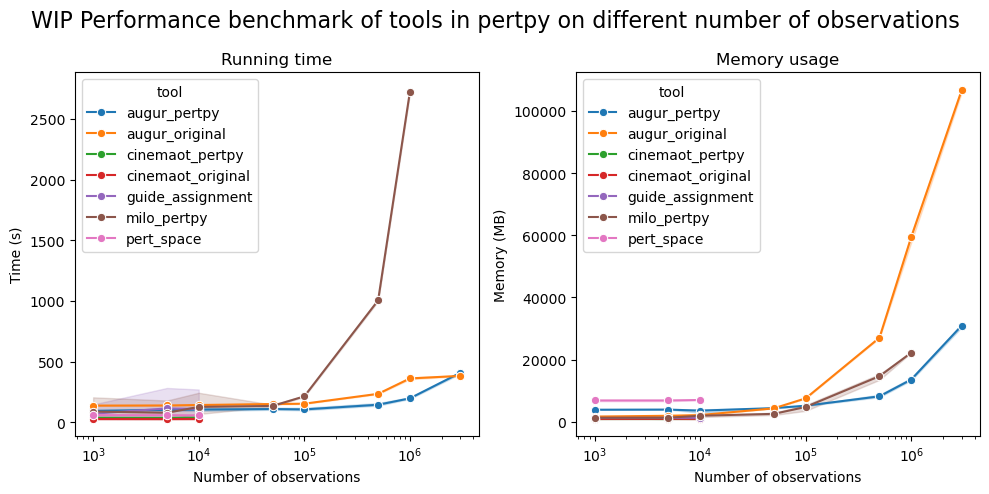

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
sns.lineplot(data=df, x='n_obs', y='s', ax=ax, marker='o', hue='tool')
ax.set_xlabel('Number of observations')
ax.set_ylabel('Time (s)')
ax.set_title('Running time')
ax.set_xscale('log')

ax = axs[1]
sns.lineplot(data=df, x='n_obs', y='max_rss', ax=ax, marker='o', hue='tool')
ax.set_xlabel('Number of observations')
ax.set_ylabel('Memory (MB)')
ax.set_title('Memory usage')
ax.set_xscale('log')
plt.suptitle('WIP Performance benchmark of tools in pertpy on different number of observations', fontsize=16)
plt.tight_layout()
plt.show()